In [1]:

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import nomic
#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime
import gc

nomic.login("nk-2LSEn5FB5h04Dn0pFLuZ9jDw7ZaMbPpYPV88wbKKASc")

import json
import os
import pickle


dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-09-17-1')
bill_meta = pickle.load(open('bill_meta.p', 'rb'))

df = dataset.maps[0].data.df
df.head()

/cis/home/tchen94/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-11-05 13:35:34.259 | INFO     | nomic.dataset:__init__:768 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-09-17-1`.
2024-11-05 13:35:35.189 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-11-05 13:35:35.191 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████| 129/129 [00:01<00:00, 85.47it/s]
2024-11-05 13:35:42.741 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|██████████| 129/129 [00:12<00:00, 10.14it/s]


,tweetId,postedAt,name,state,party,twitter_lower,chamber,years,source,id,text
0,1065633444502224896,2018-11-22 15:49:46.338,Ken Buck R-CO,CO,R,repkenbuck,House,2017_2018,PolitWoops,1203633,Happy #Thanksgiving! I hope everyone has a cha...
1,1479108462504136704,2022-01-06 15:11:52.624,Kat Cammack R-FL,FL,R,repkatcammack,House,2021_2022,PolitWoops,2857207,"RT @MorningsMaria: .@RepKatCammack: ""The Democ..."
2,85108215381102592,2011-06-26 22:12:34.438,Dennis Ross R-FL,FL,R,repdennisross,House,2011_2012,PolitWoops,35353,@CEP_Observer will have to check that out.
3,925691081026621440,2017-11-01 11:48:46.882,Richard Hudson R-NC,NC,R,reprichhudson,House,2017_2018,PolitWoops,954870,RT @BGClubCab: Thanks to @CharlotteWBB for hel...
4,1435963943533568000,2021-09-09 13:50:57.715,Chip Roy R-TX,TX,R,repchiproy,House,2021_2022,PolitWoops,2324693,RT @chiproytx: No. https://t.co/STZW0DdDz1


In [2]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [3]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:1",
)

embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<All keys matched successfully>


In [176]:
#- Should be able to re-factor so that we are not keeping n_bills copies of embeddings / text

congress_name_list= list(df['name'].unique())   
n_congresspersons = len(congress_name_list)

name_to_standardized_name = {}

for name in congress_name_list:
    chunks = name.lower().split(' ')[:2]
    if ',' in chunks[0]:
        standardized_name = chunks[1] + '_' + chunks[0][:-1]
    else:
        standardized_name = chunks[0] + '_' + chunks[1]

    name_to_standardized_name[name] = unidecode(standardized_name)
standardized_name_list = list(name_to_standardized_name.values())
    
standardize_vote = {
    'Yea': 'yea', 
    'Aye': 'yea', 
    'Nay': 'nay', 
    'No': 'nay', 
    'Not Voting': 'not voting',
    'Present': 'not voting'
    }
    
cp_metadata_by_bill = {}
for bill in bill_meta:
    cp_metadata_by_bill[bill] = {}
    
    if bill_meta[bill]['house_vote_id'] == '':
        HOUSE = False
        congress_name_list_house = []
    else:
        HOUSE = True
        
    if bill_meta[bill]['senate_vote_id'] == '':
        SENATE = False
        congress_name_list_senate = []
        
    else:
        SENATE = True
    
    
    if HOUSE:
        year, month, day = bill_meta[bill]['house_vote_date'].split('-')
        house_t = pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        house_vote_id = bill_meta[bill]['house_vote_id']
        
        df_house = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{house_vote_id}.csv', header=0)
        congress_name_list_house = df_house['matched-name'].unique()
        congress_name_list_house = [name for name in congress_name_list_house if pd.notnull(name)][:-1]
        
        
    if SENATE:
        year, month, day = bill_meta[bill]['senate_vote_date'].split('-')
        senate_t =  pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        senate_vote_id = bill_meta[bill]['senate_vote_id']
    
        df_senate = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{senate_vote_id}.csv', header=0)
        congress_name_list_senate = df_senate['matched-name'].unique()
        congress_name_list_senate = [name for name in congress_name_list_senate if pd.notnull(name)][:-1]
        
    t_dict = {'house': house_t, 'senate': senate_t}
    
    #- Add all congress persons in Atlas dataframe to name_to_standardized_name
    for name in congress_name_list:
        party=df[df['name'] == name]['party'].values[0].lower()
        
        if name in congress_name_list_house:
            vote = standardize_vote[df_house[df_house['matched-name'] == name]['vote'].values[0]]
            chamber='house'
        elif name in congress_name_list_senate:
            vote = standardize_vote[df_senate[df_senate['matched-name'] == name]['vote'].values[0]]
            chamber='senate'
        else:
            vote='n/a'
            chamber=df[df['name'] == name]['chamber'].values[0].lower()
        
        standardized_name = name_to_standardized_name[name]
                    
        if standardized_name not in cp_metadata_by_bill[bill]:
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}
        elif cp_metadata_by_bill[bill][standardized_name]['vote'] == 'n/a':
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}


In [168]:
house_vote_id = bill_meta[bi_cameral_bills[0]]['house_vote_id']
        
df_house = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{house_vote_id}.csv', header=0)
congress_name_list_house = df_house['matched-name'].unique()
congress_name_list_house = [name for name in congress_name_list_house if pd.notnull(name)][:-1]


senate_vote_id = bill_meta[bi_cameral_bills[0]]['senate_vote_id']
    
df_senate = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{senate_vote_id}.csv', header=0)
congress_name_list_senate = df_senate['matched-name'].unique()
congress_name_list_senate = [name for name in congress_name_list_senate if pd.notnull(name)][:-1]


set(congress_name_list_house) & set(congress_name_list_senate)

{'Franklin, C. Scott'}

In [167]:
bill_meta[bi_cameral_bills[0]]['house_vote_id']

'117-2021_h49'

In [48]:
# Find the intersection of the two lists
common_names = set(congress_name_list) & set(congress_name_list_senate)

# Get the count of common names
common_names_count = len(common_names)

print(f"Number of names in congress_name_list that are also in congress_name_list_senate: {common_names_count}")

Number of names in congress_name_list that are also in congress_name_list_senate: 96


In [175]:
#- Add all congress persons in Atlas dataframe to name_to_standardized_name
cp_metadata_by_ty = {}

for name in congress_name_list:
    party=df[df['name'] == name]['party'].values[0].lower()
            
    if name in congress_name_list_house:
        vote = standardize_vote[df_house[df_house['matched-name'] == name]['vote'].values[0]]
        chamber='house'
    elif name in congress_name_list_senate:
        vote = standardize_vote[df_senate[df_senate['matched-name'] == name]['vote'].values[0]]
        chamber='senate'        
    else:
        vote='n/a'
        chamber=df[df['name'] == name]['chamber'].values[0].lower()
            
    standardized_name = name_to_standardized_name[name]
    
    if standardized_name=='c._franklin':
        print(name, party, vote, chamber)
    
    if standardized_name not in cp_metadata_by_ty:
        cp_metadata_by_ty[standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}
    elif cp_metadata_by_ty[standardized_name]['vote'] == 'n/a':
        cp_metadata_by_ty[standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}


Franklin, C. Scott r nay house


In [172]:
senators_who_voted_inthisbill= [name for name, metadata in cp_metadata_by_ty.items() if metadata['chamber'] == 'senate' and metadata['vote']  in ['yea','nay'] ]
stand_congress_name_list_senate= [ name_to_standardized_name[name]  for name in congress_name_list_senate ]
set(stand_congress_name_list_senate)-set(senators_who_voted_inthisbill)

{'c._franklin', 'dan_sullivan'}

In [137]:
len(set(name_to_standardized_name.values()))

844

In [156]:
'Luján, Ben Ray' in congress_name_list_house

False

In [157]:
print(cp_metadata_by_ty[name_to_standardized_name['Ben Lujan D-NM']])

{'party': 'd', 'vote': 'yea', 'chamber': 'senate'}


In [119]:
'Ben Lujan D-NM' in congress_name_list_senate

True

In [158]:
senators_who_voted_inthisbill= [name for name, metadata in cp_metadata_by_ty.items() if metadata['chamber'] == 'senate' and metadata['vote']  in ['yea','nay'] ]

In [117]:
'Ben Lujan D-NM' in congress_name_list_house
standardize_vote[df_senate[df_senate['matched-name'] == 'Ben Lujan D-NM' ]['vote'].values[0]]

'yea'

In [122]:
name_to_standardized_name['Ben Lujan D-NM']
cp_metadata_by_ty[name_to_standardized_name['Ben Lujan D-NM']]

{'party': 'd', 'vote': 'n/a', 'chamber': 'senate'}

In [106]:
cp_metadata_by_bill[bi_cameral_bills[0]]['ben_lujan']

{'party': 'd', 'vote': 'n/a', 'chamber': 'senate'}

In [73]:
set(congress_name_list_senate)

{'Alex Padilla D-CA',
 'Angus King I-ME',
 'Baldwin, Tammy',
 'Barrasso, John',
 'Ben Cardin D-MD',
 'Ben Lujan D-NM',
 'Ben Sasse R-NE',
 'Bennet, Michael F.',
 'Bernard Sanders I-VT',
 'Bill Cassidy R-LA',
 'Bill Hagerty R-TN',
 'Blackburn, Marsha',
 'Blumenthal, Richard',
 'Booker, Cory ',
 'Boozman, John',
 'Braun, Mike',
 'Brian Schatz D-HI',
 'Brown, Sherrod',
 'Cantwell, Maria',
 'Capito, Shelley Moore',
 'Carper, Thomas ',
 'Casey, Robert Jr.',
 'Catherine Masto D-NV',
 'Chris Coons D-DE',
 'Chuck Schumer D-NY',
 'Cindy Hyde-Smith R-MS',
 'Collins, Susan ',
 'Cornyn, John',
 'Cotton, Tom',
 'Cramer, Kevin',
 'Crapo, Mike',
 'Cruz, Ted',
 'Cynthia Lummis R-WY',
 'Daines, Steve',
 'Dan Sullivan R-AK',
 'Deb Fischer R-NE',
 'Debbie Stabenow D-MI',
 'Dianne Feinstein D-CA',
 'Dick Durbin D-IL',
 'Duckworth, Tammy',
 'Ed Markey D-MA',
 'Elizabeth Warren D-MA',
 'Ernst, Joni',
 'Franklin, C. Scott',
 'Gary Peters D-MI',
 'Gillibrand, Kirsten ',
 'Graham, Lindsey',
 'Grassley, Chuck',

In [150]:
senators_who_voted_inthisbill= [name for name, metadata in cp_metadata_by_ty.items() if metadata['chamber'] == 'senate' and metadata['vote']  in ['yea','nay']    ]

In [151]:
len(senators_who_voted_inthisbill)

72

In [30]:
bi_cameral_bills = []

for bill in bill_meta:
    if bill_meta[bill]['senate_vote_id'] != '':
        bi_cameral_bills.append(bill)
        print(bill, bill_meta[bill]['senate_vote_id'])

117-HR-1319 117-2021_s110
117-HR-4346 117-2022_s271
118-HR-7888 118-2024_s150
118-HR-3746 118-2023_s146


In [55]:
senate_count = sum(1 for metadata in cp_metadata_by_bill[bi_cameral_bills[0]].values() if metadata['chamber'] == 'senate' and metadata['vote'] in ['n/a'] )
print(senate_count,bi_cameral_bills[0])

#senators_who_voted = [name for name, metadata in cp_metadata_by_bill[bi_cameral_bills[3]].items() if metadata['chamber'] == 'senate' and metadata['vote'] in ['yea', 'nay']]
#print(senators_who_voted)

84 117-HR-1319


In [5]:
with open('cmds_dict_inference.p', 'rb') as file:
    cmds_dict = pickle.load(file)

In [6]:
list(cmds_dict[bill]['retrieved'].keys())==list(cmds_dict[bill]['generated'].keys())

True

In [24]:
## in these bills, how many senate actually votes
senate_count = sum(1 for metadata in cp_metadata_by_bill[bi_cameral_bills[3]].values() if metadata['chamber'] == 'senate' and metadata['vote'] in ['yea','nay'] )
print(senate_count,bi_cameral_bills[3])

senators_who_voted = [name for name, metadata in cp_metadata_by_bill[bi_cameral_bills[3]].items() if metadata['chamber'] == 'senate' and metadata['vote'] in ['yea', 'nay']]
print(senators_who_voted)

55 118-HR-3746
['maria_cantwell', 'robert_casey', 'susan_collins', 'michael_bennet', 'tammy_duckworth', 'dick_durbin', 'ben_cardin', 'chuck_schumer', 'thomas_carper', 'catherine_masto', 'dianne_feinstein', 'jeff_merkley', 'shelley_capito', 'john_cornyn', 'richard_blumenthal', 'john_hoeven', 'deb_fischer', 'mike_lee', 'ron_johnson', 'alex_padilla', 'tammy_baldwin', 'martin_heinrich', 'tom_cotton', 'ed_markey', 'jim_risch', 'angus_king', 'mitch_mcconnell', 'joseph_manchin', 'jerry_moran', 'maggie_hassan', 'van_hollen,', 'chris_coons', 'lindsey_graham', 'mazie_hirono', 'kirsten_gillibrand', 'marsha_blackburn', 'steve_daines', 'tommy_tuberville', 'chuck_grassley', 'patty_murray', 'mike_braun', 'ron_wyden', 'christopher_murphy', 'tim_kaine', 'rand_paul', 'katie_britt', 'marco_rubio', 'john_boozman', 'j.d._vance', 'eric_schmitt', 'amy_klobuchar', 'john_fetterman', 'mike_crapo', 'mark_warner', 'lisa_murkowski']


In [26]:
bill_meta[bi_cameral_bills[3]]

{'abstract': 'To provide for a responsible increase to the debt ceiling.',
 'summary': "This bill would enact a compromise reached by House Republicans and President Biden to avert an impending fiscal crisis related to the statutory debt limit. In exchange for the continued solvency of the federal government, sought by Democrats, Republicans secured in the bill across-the-board cuts to federal spending, ending Biden's suspension of student loan repayments, adding new work requirements for SNAP and TANF, reinstituting the statutory debt limit after the 2024 elections, and more.",
 'house_vote_date': '2023-05-31',
 'senate_vote_date': '2023-06-01',
 'house_vote_id': '118-2023_h243',
 'senate_vote_id': '118-2023_s146',
 'questions': ['What is your overall position on the proposed increase to the debt ceiling in this bill?',
  'Do you support the across-the-board cuts to federal spending included in the bill? Why or why not?',
  'How do you feel about ending the suspension of student loan 

In [177]:
np.random.seed(1)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

score=accuracy_score

def get_indices_by_class(y):
    unique = np.unique(y)
            
    indices_by_class ={}
    for c in unique:
        indices_by_class[c] = np.where(y == c)[0]
        
    return indices_by_class

def get_stratified_folds(y, n_folds):
    indices_by_class = get_indices_by_class(y)
    folds = {i: {'train': [], 'test': []} for i in range(n_folds)}
        
    for c, indices in indices_by_class.items():
        test_per_fold = int(len(indices) *  (1 / n_folds))
        
        for i in range(n_folds):
            folds[i]['test']+= list(indices[i*test_per_fold: (i+1)*test_per_fold])
            
        
    for i in range(n_folds):
        folds[i]['train'] = np.array([j for j in range(len(y)) if j not in folds[i]['test']])
        folds[i]['test'] = np.array(folds[i]['test'])
        
    return folds

def get_stratified_sample(y, p):
    indices_by_class = get_indices_by_class(y)
    
    inds = []
    for c, indices in indices_by_class.items():
        temp = np.random.choice(indices, size=int(p * len(indices)), replace=False)
        inds += list(temp)
    
    return inds


def get_party_line(y, party_list): 
    party_types = np.unique(party_list)
    
    party_to_vote_dict = {}
    for party_type in party_types:
        unique, counts = np.unique(y[party_list == party_type], return_counts=True)
        party_to_vote_dict[party_type] = unique[np.argmax(counts)]
        
    return party_to_vote_dict

In [178]:
from graspologic.plot import pairplot, heatmap

party_color_dict = {'d': 'tab:blue', 'r': 'tab:red', 'i': 'tab:green', 'n/a': 'k'}
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'k'}

party_by_bill = {}
vote_by_bill = {}
chamber_by_bill = {}
name_list_2 = {}

for bill in cmds_dict:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
    
    name_list = list(cmds_dict[bill]['retrieved'].keys())
    cmds_retrieved = np.array(list(cmds_dict[bill]['retrieved'].values()))
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))

    party_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['party'] for name in name_list])
    vote_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['vote'] for name in name_list])
    name_list_2[bill] = name_list
    chamber_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['chamber'] for name in name_list]) 
    
    party_list = party_by_bill[bill]

In [184]:
# Initialize the first list
vote_list = vote_by_bill[bi_cameral_bills[0]]
voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bi_cameral_bills[0]][i] == 'senate'])
senate_name_list = [name_list_2[bi_cameral_bills[0]][i] for i in voter_inds_senate]

# Convert the initial list to a set
senate_name_set = set(senate_name_list)

# Iterate through the remaining bills and update the senate_name_set with the intersection
for bi_cameral_bill in bi_cameral_bills[1:]:
    vote_list = vote_by_bill[bi_cameral_bill]
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bi_cameral_bill][i] == 'senate'])
    temp_list = [name_list_2[bi_cameral_bill][i] for i in voter_inds_senate]
    senate_name_set &= set(temp_list)

senate_name_set

{'angus_king',
 'bernard_sanders',
 'chuck_schumer',
 'cory_booker',
 'elizabeth_warren',
 'gary_peters',
 'jack_reed',
 'john_hoeven',
 'jon_ossoff',
 'joni_ernst',
 'maggie_hassan',
 'maria_cantwell',
 'mike_braun',
 'mike_lee',
 'rand_paul',
 'richard_blumenthal',
 'sheldon_whitehouse',
 'tammy_baldwin',
 'tammy_duckworth',
 'thom_tillis',
 'tina_smith',
 'tom_cotton'}

In [ ]:
cp_entrp={}

for name in senate_name_set:
    votes = []
    for bi_cameral_bill in bi_cameral_bills:
        votes.append(cp_metadata_by_bill[bi_cameral_bill][name]['vote'])
    
    yea_count = votes.count('yea')
    p=yea_count/len(votes)

    if p==0 or p==1:
        entrop=0
    else:
        entrop=-p*np.log2(p)-(1-p)*np.log2(1-p)
    cp_entrp[name] = {'vote result': votes, 'entropy': entrop}

sorted_cp_entrp = dict(sorted(cp_entrp.items(), key=lambda item: item[1]['entropy'], reverse=True))
sorted_cp_entrp

# Print out the keys of the first 10 elements in cp_entrp
first_10_keys = list(sorted_cp_entrp.keys())[:10]
print(first_10_keys)

{'joni_ernst': {'vote result': ['nay', 'nay', 'yea', 'yea'], 'entropy': 1.0},
 'elizabeth_warren': {'vote result': ['yea', 'yea', 'nay', 'nay'],
  'entropy': 1.0},
 'maria_cantwell': {'vote result': ['yea', 'yea', 'nay', 'yea'],
  'entropy': 0.8112781244591328},
 'bernard_sanders': {'vote result': ['yea', 'nay', 'nay', 'nay'],
  'entropy': 0.8112781244591328},
 'thom_tillis': {'vote result': ['nay', 'yea', 'yea', 'yea'],
  'entropy': 0.8112781244591328},
 'tammy_baldwin': {'vote result': ['yea', 'yea', 'nay', 'yea'],
  'entropy': 0.8112781244591328},
 'tom_cotton': {'vote result': ['nay', 'nay', 'yea', 'nay'],
  'entropy': 0.8112781244591328},
 'cory_booker': {'vote result': ['yea', 'yea', 'nay', 'yea'],
  'entropy': 0.8112781244591328},
 'john_hoeven': {'vote result': ['nay', 'nay', 'nay', 'yea'],
  'entropy': 0.8112781244591328},
 'mike_lee': {'vote result': ['nay', 'nay', 'nay', 'nay'], 'entropy': 0},
 'sheldon_whitehouse': {'vote result': ['yea', 'yea', 'yea', 'yea'],
  'entropy': 

['joni_ernst', 'elizabeth_warren', 'maria_cantwell', 'bernard_sanders', 'thom_tillis', 'tammy_baldwin', 'tom_cotton', 'cory_booker', 'john_hoeven', 'mike_lee']


In [117]:
my_set = {1, 2, 3, 4, 5}
my_list = [item for item in my_set]
print(my_list)

[1, 2, 3, 4, 5]


In [118]:
list(my_set)

TypeError: 'list' object is not callable

In [127]:
for a in senate_name_set: print(a in name_list_2[bi_cameral_bills[3]])

True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
vote_list = vote_by_bill[bi_cameral_bills[0]]
voter_inds_senate_1 = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])

list1 = [name_list_2[bi_cameral_bills[0]][i] for i in voter_inds_senate_1]
list2 = [name_list_2[bi_cameral_bills[1]][i] for i in voter_inds_senate]
list3 = [name_list_2[bi_cameral_bills[2]][i] for i in voter_inds_senate]
list4 = [name_list_2[bi_cameral_bills[3]][i] for i in voter_inds_senate]

# Find the intersection of the lists
intersection = set(list1) & set(list2) & set(list3) & set(list4)

# Convert the set back to a list if needed
intersection_list = list(intersection)

print(intersection_list)

32

In [26]:
## tuning the knn k parameter:
n_folds=50
n_neighbors_list = [1,3,5,9,15,21,31,51,101]

best_score_generated = {}
argbest_score_generated = {}
std_best_generated = {}

best_score_retrieved = {}
argbest_score_retrieved = {}
std_best_retrieved = {}

std_results_dict = {}
average_results_dict = {}

for bill in cp_metadata_by_bill:
    if bill_meta[bill]['house_vote_id'] == '' or bill_meta[bill]['senate_vote_id'] =='':
        continue

    average_results_dict[bill] = {}
    std_results_dict[bill] = {}
    
    best_score_generated[bill] = -1
    argbest_score_generated[bill] = -1
    std_best_generated[bill] = -1
    
    
    best_score_retrieved[bill] = -1
    argbest_score_retrieved[bill] = -1
    std_best_retrieved[bill] = -1
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    #voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])

    n_voters_house = len(voter_inds_house)
    #n_voters_senate = len(voter_inds_senate)
        
    folds = get_stratified_folds(vote_list[voter_inds_house], n_folds)
    
    results_dict = {k: {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []} for k in n_neighbors_list}
    for k in n_neighbors_list:
        for mc in range(n_folds):
            train_inds = folds[mc]['train']
            test_inds = folds[mc]['test']
            
            for type_, cmds in cmds_dict[bill].items():
                model = KNeighborsClassifier(n_neighbors=k)
                
                cmds = np.array(list(cmds_dict[bill][type_].values()))
                model.fit(cmds[voter_inds_house][train_inds], vote_list[voter_inds_house][train_inds])

                y_pred = model.predict(cmds[voter_inds_house][test_inds])
                results_dict[k][type_].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            if k != n_neighbors_list[-1]:
                continue
                
            #- majority
            unique, return_counts = np.unique(vote_list[voter_inds_house][train_inds], return_counts=True)
            y_pred = len(test_inds) * [unique[np.argmax(return_counts)]]
            results_dict[k]['majority'].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            #- party line vote
            y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p] for p in party_list[voter_inds_house][test_inds]]
            results_dict[k]['party-line'].append(score(vote_list[voter_inds_house][test_inds], y_pred))

        if np.mean(results_dict[k]['generated']) > best_score_generated[bill]:
            best_score_generated[bill] = np.mean(results_dict[k]['generated'])
            argbest_score_generated[bill] = k
            std_best_generated[bill] = np.std(results_dict[k]['generated'])
            
        if np.mean(results_dict[k]['retrieved']) > best_score_retrieved[bill]:
            best_score_retrieved[bill] = np.mean(results_dict[k]['retrieved'])
            argbest_score_retrieved[bill] = k
            std_best_retrieved[bill] = np.std(results_dict[k]['retrieved'])
            
    for type_, results in results_dict[k].items():
        average_results_dict[bill][type_] = np.mean(results)
        std_results_dict[bill][type_] = np.std(results)
        
    average_results_dict[bill]['retrieved'] = best_score_retrieved[bill]
    average_results_dict[bill]['generated'] = best_score_generated[bill]
    
    std_results_dict[bill]['retrieved'] = std_best_retrieved[bill]
    std_results_dict[bill]['generated'] = std_best_generated[bill]
    
    print(average_results_dict[bill])
    print()

{'retrieved': 0.53, 'generated': 0.84, 'majority': 0.5, 'party-line': 0.99}

{'retrieved': 0.61, 'generated': 0.84, 'majority': 0.5, 'party-line': 0.99}

{'retrieved': 0.6666666666666665, 'generated': 0.7266666666666666, 'majority': 0.6666666666666665, 'party-line': 0.6133333333333334}

{'retrieved': 0.7066666666666666, 'generated': 0.6866666666666665, 'majority': 0.6666666666666665, 'party-line': 0.6666666666666665}



117-HR-1319 0.84
117-HR-4346 0.84
118-HR-7888 0.7266666666666666
118-HR-3746 0.6866666666666665


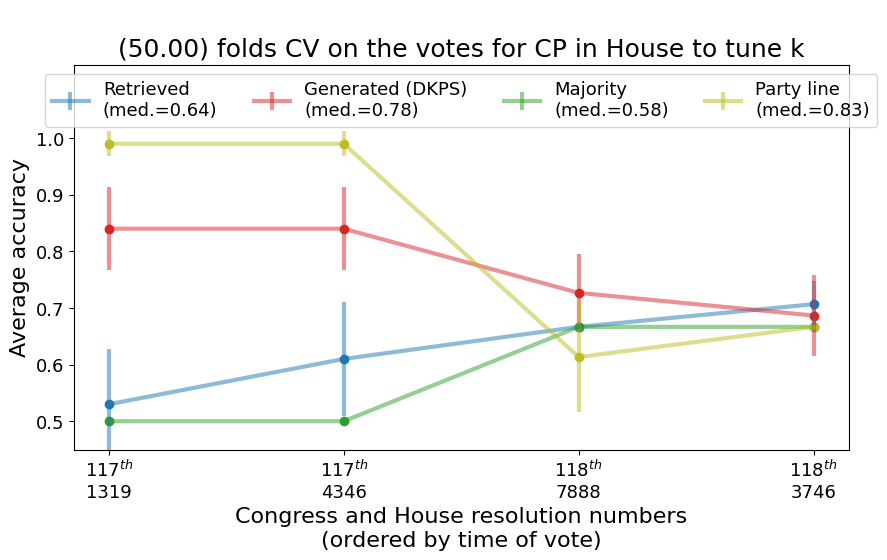

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bill_list = list(average_results_dict.keys())
# bill_list.remove('118-HR 1435')

method_list = list(average_results_dict[bill_list[0]].keys())

bill_labels= []
for bill in bill_list:
    if bill == '118-HR 1435':
        bill_labels.append(r'118$^{th}$'+'\n1435')
        continue
    split = bill.split('-')
    bill_labels.append(f'{split[0]}' + r'$^{th}$' + '\n' + split[2])

# markers=['*', '^', 'v']
# bill_to_marker = {bill: markers[i] for i, bill in enumerate(bill_list)}

colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:olive']
method_to_color = {method: colors[i] for i, method in enumerate(method_list)}

legend_dict = {
    'retrieved': 'Retrieved', 
    'generated': 'Generated (DKPS)',
    'majority': 'Majority', 
    'party-line': 'Party line'
}

result_by_method = {method: [] for method in method_list}
std_by_method = {method: [] for method in method_list}
for i, bill in enumerate(bill_list):
    for j, (method, avg) in enumerate(average_results_dict[bill].items()):
        if method == 'generated':
            print(bill, avg)
        ax.scatter(i, avg, color=method_to_color[method])
        result_by_method[method].append(avg)
        std_by_method[method].append(std_results_dict[bill][method])
    
for method in result_by_method:
    median = np.median(result_by_method[method])
    ax.errorbar(range(len(bill_list)), result_by_method[method], yerr=std_by_method[method] / np.sqrt(10), color=method_to_color[method], alpha=0.5, lw=3, 
                label=legend_dict[method]+f'\n(med.={median:1.2f})')
    
ax.set_xticks(range(len(bill_list)), labels=bill_labels)
ax.set_xlabel('Congress and House resolution numbers\n(ordered by time of vote)', fontsize=16)
ax.tick_params(labelsize=13)
ax.set_ylabel('Average accuracy', fontsize=16)
ax.set_title( f'\n({n_folds:1.2f}) folds CV on the votes for CP in House to tune k', fontsize=18)
# ax.set_xlim(-.05, 2.05)
ax.set_ylim(0.45, 1.13)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.legend(fontsize=13, loc='upper center', ncols=4)


In [29]:
argbest_score_retrieved

{'117-HR-1319': 51, '117-HR-4346': 21, '118-HR-7888': 101, '118-HR-3746': 15}

In [30]:
## predict on the senate vote

results_dict_senate = {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []}

for bill in argbest_score_generated.keys():
    
    ## train on all house votes
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    #- majority
    unique, return_counts = np.unique(vote_list[voter_inds_house], return_counts=True)
    y_pred = len(voter_inds_senate) * [unique[np.argmax(return_counts)]]
    results_dict_senate['majority'].append(score(vote_list[voter_inds_senate], y_pred))


    #- party line vote
    y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p if p != 'i' else 'd'] for p in party_list[voter_inds_senate]]
    results_dict_senate['party-line'].append(score(vote_list[voter_inds_senate], y_pred))

    n_voters_house = len(voter_inds_house)
    
    #- generated 
    k = argbest_score_generated[bill]
    model = KNeighborsClassifier(n_neighbors=k)
                
    cmds = np.array(list(cmds_dict[bill]['generated'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])

    y_pred = model.predict(cmds[voter_inds_senate])
    results_dict_senate['generated'].append(score(vote_list[voter_inds_senate], y_pred))
    
    #-retrieved
    k = argbest_score_retrieved[bill]
    model = KNeighborsClassifier(n_neighbors=k)
    
    cmds = np.array(list(cmds_dict[bill]['retrieved'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])
    
    y_pred = model.predict(cmds[voter_inds_senate])
    results_dict_senate['retrieved'].append(score(vote_list[voter_inds_senate], y_pred))
    
        
    print(average_results_dict[bill])    

{'retrieved': 0.53, 'generated': 0.84, 'majority': 0.5, 'party-line': 0.99}
{'retrieved': 0.61, 'generated': 0.84, 'majority': 0.5, 'party-line': 0.99}
{'retrieved': 0.6666666666666665, 'generated': 0.7266666666666666, 'majority': 0.6666666666666665, 'party-line': 0.6133333333333334}
{'retrieved': 0.7066666666666666, 'generated': 0.6866666666666665, 'majority': 0.6666666666666665, 'party-line': 0.6666666666666665}
